# Module 2 - Wrap-Up Quiz

## Importing Pandas

In [1]:
import pandas as pd

## Loading Data

In [2]:
blood_transfusion = pd.read_csv("../datasets/blood_transfusion.csv")
target_name = "Class"
data = blood_transfusion.drop(columns=target_name)
target = blood_transfusion[target_name]
# Checking data
data.head()

Recency  Frequency  Monetary  Time
0        2         50     12500    98
1        0         13      3250    28
2        1         16      4000    35
3        2         20      5000    45
4        1         24      6000    77

## Checking target type and imbalance

In [3]:
target.value_counts()

Class
not donated    570
donated        178
Name: count, dtype: int64

We can also use the `value_count()` method with the option `normalize=True`, which returns normalized values.

In [4]:
target.value_counts(normalize=True)

Class
not donated    0.762032
donated        0.237968
Name: proportion, dtype: float64

## Baseline accuracy using DummyClassifier

In [5]:
from sklearn.dummy import DummyClassifier
# since we only care for the test score, we will replace cross_validate with cross_val_score
from sklearn.model_selection import cross_val_score

baseline_model = DummyClassifier(strategy='most_frequent')

scores = cross_val_score(baseline_model, data, target, cv=10)

print(
    "The mean cross-validation accuracy is: "
    f"{scores.mean():.3f} ± {scores.std():.3f} "
)

The mean cross-validation accuracy is: 0.762 ± 0.004 


N.B. The obtained accuracy is nothing but $$\frac{number_{\text{not donated}}}{number_{\text{not donated}}+number_{\text{donated}}}=\frac{570}{570+178}=0.762$$

With `scoring="balanced_accuracy"` 

In [6]:
scores = cross_val_score(baseline_model, data, target, cv=10, scoring="balanced_accuracy")

print(
    "The mean cross-validation accuracy is: "
    f"{scores.mean():.3f} ± {scores.std():.3f} "
)

The mean cross-validation accuracy is: 0.500 ± 0.000 


Which makes sense, since for a balanced dataset would have $number_{\text{not donated}}=number_{\text{donated}}$.

However, `balanced accuracy` is defined as the average of recall obtained on each class. More reading in [link 1](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html#sklearn.metrics.balanced_accuracy_score) and [link 2](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score).

## KNN Model

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier

model = make_pipeline(StandardScaler(), KNeighborsClassifier())

Inspect the parameters of the created pipeline. What is the value of K, the number of neighbors considered when predicting with the k-nearest neighbors?

In [17]:
# Checking model parameters
model.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('kneighborsclassifier', KNeighborsClassifier())],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'kneighborsclassifier': KNeighborsClassifier(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'kneighborsclassifier__algorithm': 'auto',
 'kneighborsclassifier__leaf_size': 30,
 'kneighborsclassifier__metric': 'minkowski',
 'kneighborsclassifier__metric_params': None,
 'kneighborsclassifier__n_jobs': None,
 'kneighborsclassifier__n_neighbors': 5,
 'kneighborsclassifier__p': 2,
 'kneighborsclassifier__weights': 'uniform'}

Since we did not specify any parameters for the `KNeighborsClassifier`, we can also check the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) to know the default number of neighbors.

Set `n_neighbors=1` in the previous model and evaluate it using a 10-fold cross-validation. Use the balanced accuracy as a score. What can you say about this model? Compare the average of the train and test scores to argument your answer.

One way to change the parameters of a model after creating an instance is to use the `set_params()` method.

In [74]:
model.set_params(kneighborsclassifier__n_neighbors=1)
model.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=1))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'kneighborsclassifier': KNeighborsClassifier(n_neighbors=1),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'kneighborsclassifier__algorithm': 'auto',
 'kneighborsclassifier__leaf_size': 30,
 'kneighborsclassifier__metric': 'minkowski',
 'kneighborsclassifier__metric_params': None,
 'kneighborsclassifier__n_jobs': None,
 'kneighborsclassifier__n_neighbors': 1,
 'kneighborsclassifier__p': 2,
 'kneighborsclassifier__weights': 'uniform'}

In [75]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(model, data, target, cv=10, return_train_score=True, scoring="balanced_accuracy")

train_scores = cv_results["train_score"]
test_scores = cv_results["test_score"]

print(
    "The mean cross-validation train accuracy is: "
    f"{train_scores.mean():.3f} ± {train_scores.std():.3f} "
)
print(
    "The mean cross-validation test accuracy is: "
    f"{test_scores.mean():.3f} ± {test_scores.std():.3f} "
)

The mean cross-validation train accuracy is: 0.883 ± 0.008 
The mean cross-validation test accuracy is: 0.484 ± 0.105 


The model clearly overfits since it has a high train accuracy of 0.883 and a low (almost by half) test accuracy of 0.484. The `KneighborsClassifier` overfits when the number of neighbors is small. The model is 'less complex' and is more sensitive to noise as it only considers one neighbors. Therefore, the model overfits with small Ks. A ballpark estimate would be to start with $K=\log(n_{samples})$ and increase K. More details in this [link](https://stats.stackexchange.com/questions/384542/how-to-prevent-overfitting-with-knn).

## Hyperparameter Tuning

We can change the hyperparameter using a for loop

In [65]:
param_range = [1, 2, 5, 10, 20, 50, 100, 200, 500]
train_scores = []
test_scores = []
# Looping over param_range
for i in param_range:
    model.set_params(kneighborsclassifier__n_neighbors=i)
    print(f"K = {model.get_params()['kneighborsclassifier__n_neighbors']}")
    print('-'*25)
    cv_results = cross_validate(model, data, target, cv=5, return_train_score=True, scoring="balanced_accuracy")
    train_scores.append(cv_results["train_score"].mean())
    test_scores.append(cv_results["test_score"].mean())
    print(f"{'avg. train score:':<20}{train_scores[-1]:.3f}")
    print(f"{'avg. test score:':<20}{test_scores[-1]:.3f}\n")

K = 1
-------------------------
avg. train score:   0.890
avg. test score:    0.490

K = 2
-------------------------
avg. train score:   0.842
avg. test score:    0.501

K = 5
-------------------------
avg. train score:   0.710
avg. test score:    0.515

K = 10
-------------------------
avg. train score:   0.697
avg. test score:    0.554

K = 20
-------------------------
avg. train score:   0.678
avg. test score:    0.601

K = 50
-------------------------
avg. train score:   0.624
avg. test score:    0.568

K = 100
-------------------------
avg. train score:   0.536
avg. test score:    0.554

K = 200
-------------------------
avg. train score:   0.500
avg. test score:    0.500

K = 500
-------------------------
avg. train score:   0.500
avg. test score:    0.500



Plotting results

Text(0, 0.5, 'Avg. Accuracy')

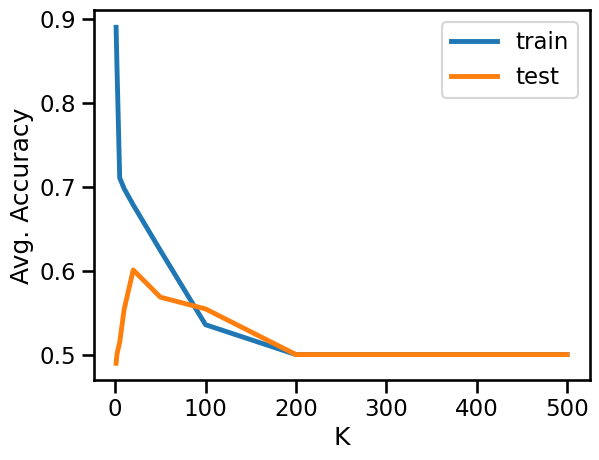

In [68]:
import matplotlib.pyplot as plt

plt.plot(param_range, train_scores, label = 'train')
plt.plot(param_range, test_scores, label = 'test')
plt.legend()
plt.xlabel('K')
plt.ylabel('Avg. Accuracy')

Or, We can use `ValidationCurveDisplay`

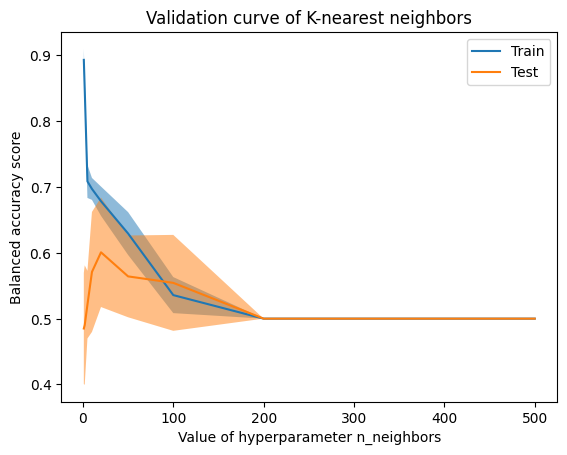

In [13]:
import numpy as np
from sklearn.model_selection import ValidationCurveDisplay

param_range = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500])

disp = ValidationCurveDisplay.from_estimator(
    model,
    data,
    target,
    param_name="kneighborsclassifier__n_neighbors",
    param_range=param_range,
    scoring="balanced_accuracy",
    n_jobs=2,
)

_ = disp.ax_.set(
    xscale="linear",
    xlabel="Value of hyperparameter n_neighbors",
    ylabel="Balanced accuracy score",
    title="Validation curve of K-nearest neighbors",
)

For more info on `xscale`, use [this link](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xscale.html)

## Testing the effect of StandardScalar

In [101]:
# Simple KNeighborsClassifier
model_1 = KNeighborsClassifier(n_neighbors=10)
# KNeighborsClassifier with StandardScaler
model_2 = make_pipeline(StandardScaler(), model_1)

In [102]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(model_1, data, target, cv=10, return_train_score=True, scoring="balanced_accuracy")

train_scores = cv_results["train_score"]
test_scores = cv_results["test_score"]
time = cv_results["fit_time"]

print(
    "The mean cross-validation train accuracy is: "
    f"{train_scores.mean():.3f} ± {train_scores.std():.3f} "
)
print(
    "The mean cross-validation test accuracy is: "
    f"{test_scores.mean():.3f} ± {test_scores.std():.3f} "
)
print(
    "The mean fit time is: "
    f"{1000*time.mean():.2f} ms ± {1000*time.std():.2f} ms"
)

The mean cross-validation train accuracy is: 0.666 ± 0.010 
The mean cross-validation test accuracy is: 0.539 ± 0.034 
The mean fit time is: 3.17 ms ± 0.44 ms


In [103]:
cv_results = cross_validate(model_2, data, target, cv=10, return_train_score=True, scoring="balanced_accuracy")

train_scores = cv_results["train_score"]
test_scores = cv_results["test_score"]
time = cv_results["fit_time"]

print(
    "The mean cross-validation train accuracy is: "
    f"{train_scores.mean():.3f} ± {train_scores.std():.3f} "
)
print(
    "The mean cross-validation test accuracy is: "
    f"{test_scores.mean():.3f} ± {test_scores.std():.3f} "
)
print(
    "The mean fit time is: "
    f"{1000*time.mean():.2f} ms ± {1000*time.std():.2f} ms"
)

The mean cross-validation train accuracy is: 0.685 ± 0.020 
The mean cross-validation test accuracy is: 0.550 ± 0.080 
The mean fit time is: 4.86 ms ± 1.43 ms


For this specific dataset, we do not see a drastic improvement in the model performance. However, The k-nearest neighbor algorithm relies on majority voting based on class membership of 'k' nearest samples for a given test point. The nearness of samples is typically based on Euclidean distance. Without normalization, the nearest neighbors are mainly defined by the feature with the bigger range/numbers, which leads to incorrect classification.

Normalization and Standardization helps solve the problem, as most feature will lie more or less on the same range, therefore contributing approximately equally to the distance computation. 

For more reading:
* [Should I normalize or standardize my dataset for knn?](https://stackoverflow.com/questions/55073423/should-i-normalize-or-standardize-my-dataset-for-knn)
* [Accuracy difference on normalization in KNN](https://stackoverflow.com/questions/42092448/accuracy-difference-on-normalization-in-knn?rq=3)
* [Why do you need to scale data in KNN](https://stats.stackexchange.com/questions/287425/why-do-you-need-to-scale-data-in-knn)